In [11]:
import torch
import torch.nn.functional as F

import torchsde
import math
import matplotlib.pyplot as plt

from cfollmer.objectives import log_g, relative_entropy_control_cost, gaussian_prior
from cfollmer.sampler_utils import FollmerSDE
import numpy as np

from tqdm.notebook import tqdm

from torch import _vmap_internals

## Generating Toy 2D Dataset.

In [21]:
import torch
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

device = "cuda" if torch.cuda.is_available() else "cpu"
random_state = 170

X, y = make_blobs(n_samples=100,
                  cluster_std=[0.5, 0.5, 0.5],
                  random_state=random_state)


# # Scale data to have mean 0 and variance 1 
# # which is importance for convergence of the neural network
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data set into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=2)


X_train, X_test, y_train, y_test = \
    torch.tensor(X_train, dtype=torch.float32, device=device), \
    torch.tensor(X_test, dtype=torch.float32, device=device), \
    torch.tensor(y_train, dtype=torch.float32, device=device), \
    torch.tensor(y_test, dtype=torch.float32, device=device) 

In [22]:
X.shape

(100, 2)

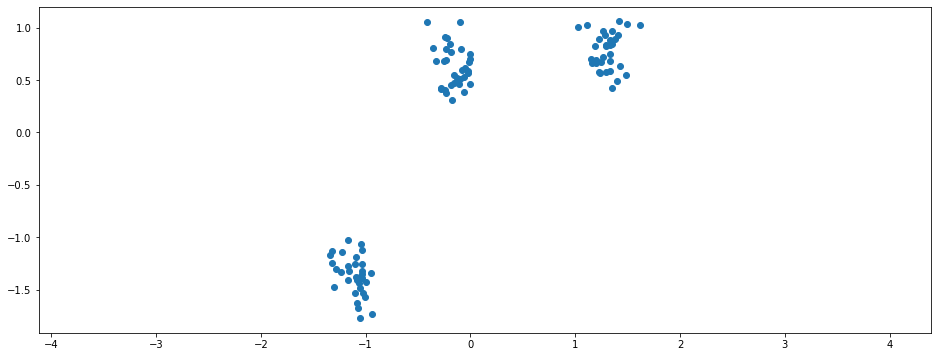

In [84]:
fig, ax1 = plt.subplots(1, 1, figsize=(16, 6))

ax1.plot(X_scaled[:, 0], X_scaled[:, 1], 
         linestyle='none', 
         marker='o')

ax1.axis('equal');

$$\DeclareMathOperator*{\argmin}{arg\,min}$$
$$\def\E{{\mathbb{E}}}$$
$$\def\rvu{{\mathbf{u}}}$$
$$\def\rvTheta{{\bm{\Theta}}}$$
$$\def\gU{{\mathcal{U}}}$$
$$\def\mX{{\mathbf{X}}}$$

## Controlled Schrodinger Follmer Sampler

The objevtive we are trying to implement is:

\begin{align}
  \mathbf{u}_t^{*}=  \argmin_{\rvu_t \in \mathcal{U}}\mathbb{E}\left[\frac{1}{2\gamma}\int_0^1||\rvu(t, \Theta_t)||^2 dt - \ln\left(\frac{ p(\mX | \Theta_1)p(\Theta_1)}{\mathcal{N}(\Theta_1|\mathbf{0}, \gamma \mathbb{I} )}\right)\right] \
\end{align}

Where:
\begin{align}
d\Theta_t = \rvu(t, \Theta_t)dt + \sqrt{\gamma} dB_t
\end{align}

To do so we use the EM discretisation.

In [85]:
def log_gaussian(x, mean=0):
    """
    Returns the density of x under the supplied gaussian. Defaults to
    standard gaussian N(0, I)
    :param x: (*) torch.Tensor
    :param mean: float or torch.FloatTensor with dimensions (*)
    :param logvar: float or torch.FloatTensor with dimensions (*)
    :return: (*) elementwise log density
    """
    
    log_norm_constant = -0.5 * np.log(2 * np.pi)
    logvar = torch.log(torch.tensor(0.1))
    logvar = x.new(1).fill_(logvar)
    
    a = (x - mean) ** 2
    log_p = -0.5 * (logvar + a / logvar.exp())
    log_p = log_p + log_norm_constant

    return log_p.sum(dim=-1)


def log_likelihood_single(μ, X, log=True):
    """
    :param X: design matrix (examples, features)
    :param mu: the component means (K, features)
    :param logvar: the component log-variances (K, features)
    :param log: return value in log domain?

    """
#     import pdb; pdb.set_trace()
    
    n, d = X.shape
    # get feature-wise log-likelihoods (K, examples, features)
    log_likelihoods = log_gaussian(
        X[None, :, :], # (1, examples, features)
        μ.reshape(-1, d)[:, None, :], # (K, 1, features)
    )

    # sum over the feature dimension
    log_likelihoods = torch.logsumexp(log_likelihoods, dim=0) 

    return log_likelihoods.sum()


def log_likelihood(Θ, X, y=None):
    """
    batching the above (hopefully its right)
    """
#     import pdb; pdb.set_trace()
    loss_ = lambda μ: log_likelihood_single(μ, X)
    
    batched_loss =  torch._vmap_internals.vmap(loss_)

    return batched_loss(Θ)

In [86]:
Δt=0.05
t_size = int(math.ceil(1.0/Δt))
dim = 3 * 2

ts = torch.linspace(0, 1, t_size).to(device)
no_posterior_samples = 50

sde = FollmerSDE(dim, dim, no_posterior_samples, 1.0, device=device).to(device)
Θ_0 = torch.zeros((no_posterior_samples, dim)).to(device) # Θ_0 ~ δ_0

# Initial state y0, the SDE is solved over the interval [ts[0], ts[-1]].
# ys will have shape (t_size, batch_size, state_size)
ys = torchsde.sdeint(sde, Θ_0, ts, dt=Δt)

In [87]:
relative_entropy_control_cost(sde, Θ_0, X_train, y_train, 
                              gaussian_prior, log_likelihood, γ=1.0, device=device)

C:\Users\vargf\anaconda3\lib\site-packages\torch\_vmap_internals.py:252: UserWarning: torch.vmap is an experimental prototype that is subject to change and/or deletion. Please use at your own risk.
  warnings.warn(
<ipython-input-85-2e8c864ddd5f>:40: UserWarning: Batching rule not implemented for aten::logsumexp falling back to slow (for loop and stack) implementation (Triggered internally at  ..\aten\src\ATen\BatchedFallback.cpp:63.)
  log_likelihoods = torch.logsumexp(log_likelihoods, dim=0)
<ipython-input-85-2e8c864ddd5f>:42: UserWarning: Batching rule not implemented for aten::sum falling back to slow (for loop and stack) implementation (Triggered internally at  ..\aten\src\ATen\BatchedFallback.cpp:63.)
  return log_likelihoods.sum()


tensor(1286.0779, device='cuda:0', grad_fn=<MeanBackward0>)

In [88]:
γ = 1.0
Δt=0.05
t_size = int(math.ceil(1.0/Δt))
print(t_size)
ts = torch.linspace(0, 1, t_size).to(device)

sde = FollmerSDE(dim, dim, no_posterior_samples  , γ=γ, device=device).to(device)
optimizer = torch.optim.Adam(sde.μ.parameters(), lr=0.09, weight_decay =1)
#     optimizer = torch.optim.LBFGS(gpr.parameters(), lr=0.01)
losses = []
num_steps = 100
for i in tqdm(range(num_steps)):
    optimizer.zero_grad()

    if isinstance(optimizer, torch.optim.LBFGS):
        def closure():
            loss = relative_entropy_control_cost(
                sde, Θ_0.float(),
                X_train.float(), y_train.float(),
                gaussian_prior, log_likelihood, γ=γ
            )
            optimizer.zero_grad()
            loss.backward()
            return loss

        optimizer.step(closure)
        losses.append(closure().item())
    else:
        loss = relative_entropy_control_cost(
            sde, Θ_0,
            X_train, y_train,
            gaussian_prior, log_likelihood, γ=γ
        )
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        losses.append(loss.item())

20


  0%|          | 0/100 [00:00<?, ?it/s]

<ipython-input-85-2e8c864ddd5f>:40: UserWarning: Batching rule not implemented for aten::logsumexp falling back to slow (for loop and stack) implementation (Triggered internally at  ..\aten\src\ATen\BatchedFallback.cpp:63.)
  log_likelihoods = torch.logsumexp(log_likelihoods, dim=0)
<ipython-input-85-2e8c864ddd5f>:42: UserWarning: Batching rule not implemented for aten::sum falling back to slow (for loop and stack) implementation (Triggered internally at  ..\aten\src\ATen\BatchedFallback.cpp:63.)
  return log_likelihoods.sum()


In [89]:
losses

[1148.671875,
 442.32818603515625,
 2309.281494140625,
 378.5138244628906,
 494.181640625,
 638.5601196289062,
 818.047119140625,
 563.2620849609375,
 480.9657287597656,
 705.0221557617188,
 502.9326171875,
 510.2657165527344,
 405.9010925292969,
 350.9248352050781,
 361.4313659667969,
 320.98065185546875,
 322.3826904296875,
 356.8143615722656,
 344.99822998046875,
 290.52386474609375,
 304.35113525390625,
 278.216552734375,
 324.99072265625,
 257.6805419921875,
 315.2677001953125,
 281.2933349609375,
 301.71160888671875,
 275.4434509277344,
 274.9703369140625,
 282.5225830078125,
 279.0531005859375,
 255.0511474609375,
 237.19639587402344,
 267.3143615722656,
 249.56753540039062,
 219.07017517089844,
 273.6348876953125,
 236.5558319091797,
 244.89599609375,
 225.08058166503906,
 223.28575134277344,
 270.2176208496094,
 245.63912963867188,
 245.95843505859375,
 272.2038879394531,
 247.416748046875,
 235.0045623779297,
 251.0233917236328,
 221.9027557373047,
 202.02479553222656,
 226.1

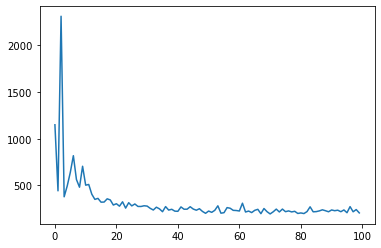

In [90]:
plt.plot(losses[:])

In [91]:
 torchsde.sdeint(sde, Θ_0, ts, method="euler", dt=Δt).shape

torch.Size([20, 50, 6])

In [92]:
X_train.shape

torch.Size([80, 2])

In [93]:
Θ_1 = torchsde.sdeint(sde, Θ_0, ts, dt=Δt)[-1,...]

In [98]:
Θ_1 = Θ_1.reshape(50,3,2)

(array([ 6., 14., 22.,  9.,  6., 15., 29., 35., 11.,  3.]),
 array([-2.0373082e+00, -1.6298347e+00, -1.2223612e+00, -8.1488764e-01,
        -4.0741414e-01,  5.9366226e-05,  4.0753287e-01,  8.1500638e-01,
         1.2224799e+00,  1.6299534e+00,  2.0374269e+00], dtype=float32),
 <a list of 10 Patch objects>)

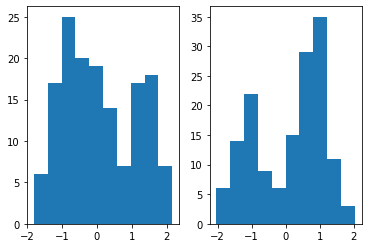

In [100]:
fig, (ax1,ax2) = plt.subplots(1,2)

ax1.hist(Θ_1[:,:,0].flatten().cpu().detach().numpy())
ax2.hist(Θ_1[:,:,1].flatten().cpu().detach().numpy())

In [95]:
Θ_1.mean(axis=0).reshape(3,2)

tensor([[ 1.3344,  1.0284],
        [-0.0843,  0.4886],
        [-0.9756, -1.1666]], device='cuda:0', grad_fn=<ViewBackward>)

## MAP Baseline

We run the point estimate approximation (Maximum a posteriori) to double check what the learned weights look like.  We get the  exact same training accuracy as with the controlled model and similarly large weights for the non bias weights. 

In [22]:
Θ_map = torch.full((1, dim), 0.0, requires_grad=True)  
optimizer_map = torch.optim.Adam([Θ_map], lr=0.05)
#     optimizer = torch.optim.LBFGS(gpr.parameters(), lr=0.01)

losses_map = []
num_steps = 1000
for i in tqdm(range(num_steps)):
    optimizer.zero_grad()

    if isinstance(optimizer_map, torch.optim.LBFGS):
        def closure_map():
            loss_map = log_likelihood_vmap()
            optimizer_map.zero_grad()
            loss_map.backward()
            return loss

        optimizer_map.step(closure_map)
        losses_map.append(closure_map().item())
    else:
        loss_map = -(log_likelihood_vmap(Θ_map, (X_train).float(), (y_train).float()) + gaussian_prior(Θ_map))
        optimizer_map.zero_grad()
        loss_map.backward()

        optimizer_map.step()
        losses_map.append(loss.item())

Θ_map
pred_map = torch.sigmoid(X_train.float().mm(Θ_map.T)).mean(axis=1)
((pred_map < 0.5).float() == y_train).float().mean(), Θ_map

  0%|          | 0/1000 [00:00<?, ?it/s]

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking arugment for argument mat2 in method wrapper_mm)